<a href="https://colab.research.google.com/github/bd1ng/Interperable_Reg/blob/main/interp_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #01 Regression Interpretability

### Includes EDA to check assumptions, linear regression to predict churn, logistic regression to predict probability of churn, and GAM to model non-linear relationships. Includes a discussion of model strenghts and weaknesses, and a recommendation.

### Bochu Ding

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bd1ng/Interperable_Reg/blob/main/interp_reg.ipynb)

# 0. Setup

In [4]:
# Install pygam
!pip install pygam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 18.9 MB/s eta 0:00:00


In [5]:
#Import Libraries

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, log_loss
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import Logit
from statsmodels.tools import add_constant
from pygam import LogisticGAM, s, PackageNotFoundError

In [7]:
#Connect Github & Colab

repo_name = "Interperable_Reg"
git_path = 'https://github.com/bd1ng/Interperable_Reg.git'
!git clone "{git_path}"
path_to_notebook = os.path.join(repo_name)
%cd "{path_to_notebook}"
%ls

Cloning into 'Interperable_Reg'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 504.79 KiB | 1.59 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/Interperable_Reg
interp_reg.ipynb  README.md  telco_churn.csv


#1. EDA for Checking Assumptions

## Data Cleaning

In [10]:
# Load Dataset
df = pd.read_csv("telco_churn.csv")
df = df.drop(columns = 'customerID')

# Update Data Type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype('float64')

# Revise Format for Regression
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})

# Change Boolean Columns to Dummy Variables
yn_col = [2,3,5,15,19]
yn_col = [df.columns[i] for i in yn_col] #troubleshooted by GPT4o on 1/22/2025 at 10:06p

for col in yn_col:
  df[col] = df[col].replace({'No':0,'Yes':1})

# Change Boolean Columns to Dummy Variables - For these columns, assume NA = No
ynx_col = [6,8,9,10,11,12,13]
ynx_col = [df.columns[i] for i in ynx_col]
for col in ynx_col:
  df[col] = df[col].replace({'No':0, 'Yes':1})
  df[col] = df[col].apply(lambda x: 0 if x not in [1, 0] else x) #refined with help of GPT4o on 1/22/2025 at 9:06p

# Set up Internet Service Dummy
df['InternetServiceType'] = df['InternetService']

# One Hot Encoding - Drop first column to avoid dummy variable trap
hot_col = [14, 16]
hot_col = [df.columns[i] for i in hot_col]
df_encoded = pd.get_dummies(df, columns=hot_col, drop_first=True) #generated by GPT4o on 1/22/2025 at 9:16p

# One Hot Encoding - Custom drop "No"
df_internet = pd.get_dummies(df['InternetServiceType'], drop_first = False)
df_internet = df_internet.drop(columns = 'No')
df = pd.concat([df_encoded,df_internet], axis=1) #refined by GPT4o on 1/22/2025 at 10:16p

# Transform Booleans into Dummary Variables
bool_col = range(19,26) #corrected by GPT4o at 10:25p
bool_col = [df.columns[i] for i in bool_col]
for col in bool_col:
  df[col] = df[col].astype(int)

# Final clean-up for regression
df = df.drop(columns = ['InternetService','InternetServiceType'])
df = df.dropna()
df = df.apply(pd.to_numeric, errors='coerce')

df.head(10)


<ipython-input-10-b1974f542578>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})
<ipython-input-10-b1974f542578>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'No':0,'Yes':1})


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,DSL,Fiber optic
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,1,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,1,0,0,0,1,1,0
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,1,1,0
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,1,0,0,0,0,1,0
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,0,0,0,1,0,0,1
5,1,0,0,0,8,1,1,0,0,1,...,99.65,820.50,1,0,0,0,1,0,0,1
6,0,0,0,1,22,1,1,0,1,0,...,89.10,1949.40,0,0,0,1,0,0,0,1
7,1,0,0,0,10,0,0,1,0,0,...,29.75,301.90,0,0,0,0,0,1,1,0
8,1,0,1,0,28,1,1,0,0,1,...,104.80,3046.05,1,0,0,0,1,0,0,1
9,0,0,0,1,62,1,0,1,1,0,...,56.15,3487.95,0,1,0,0,0,0,1,0


## Linearity

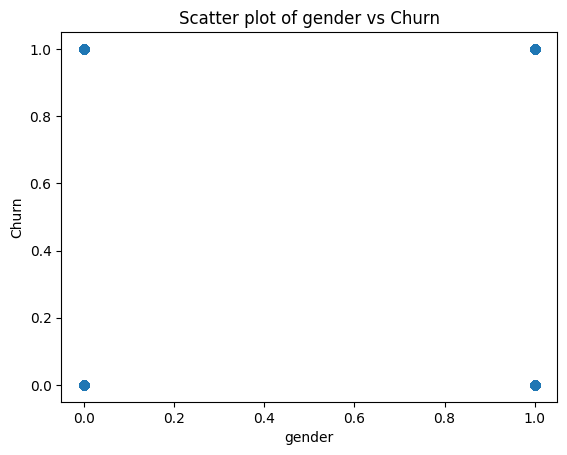

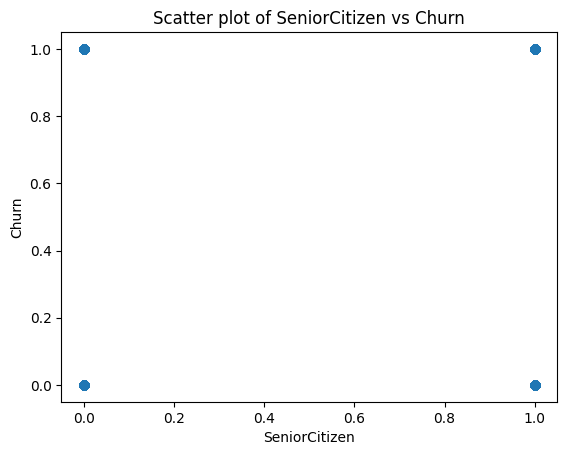

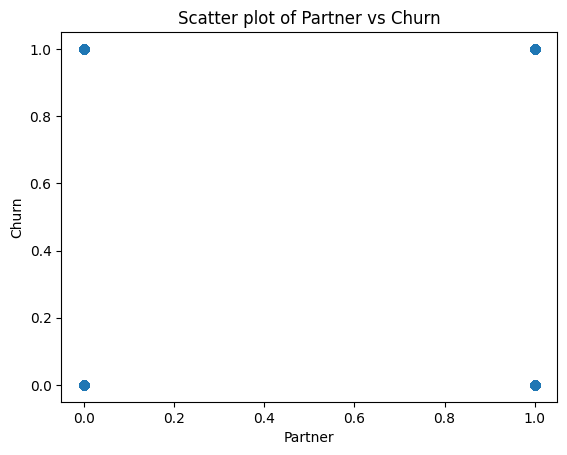

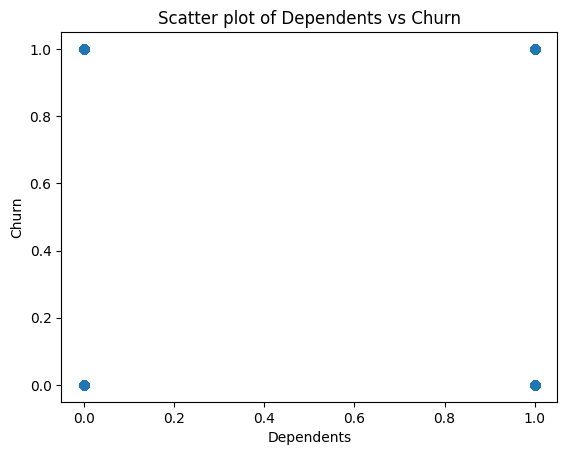

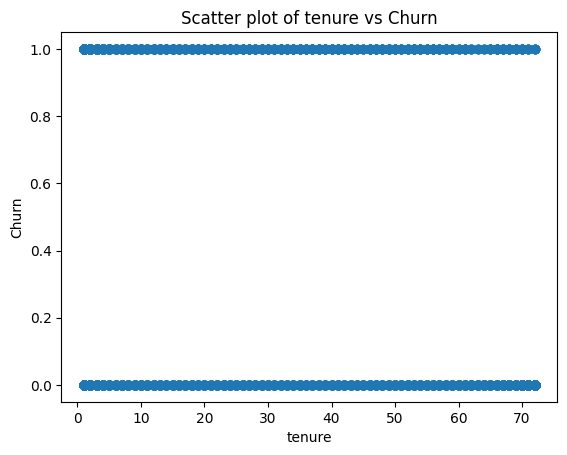

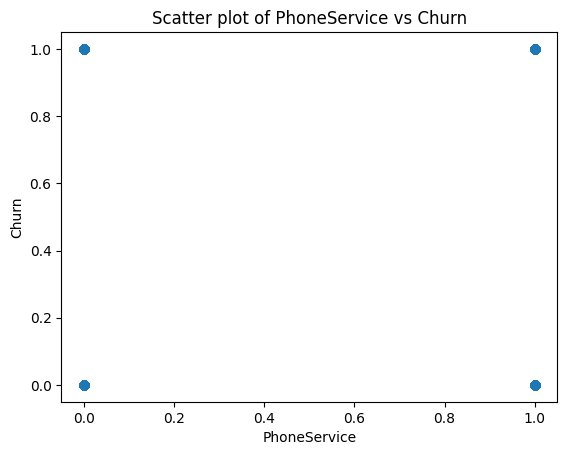

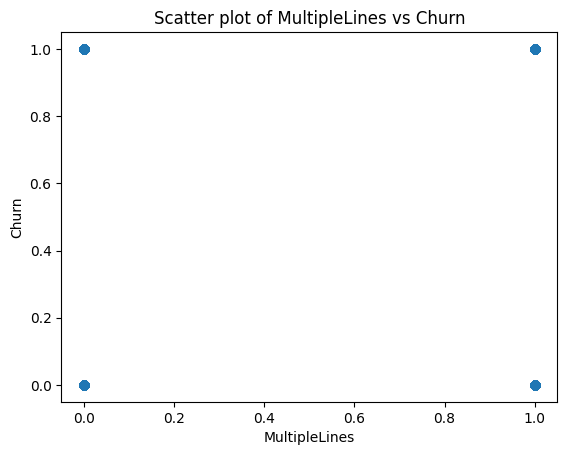

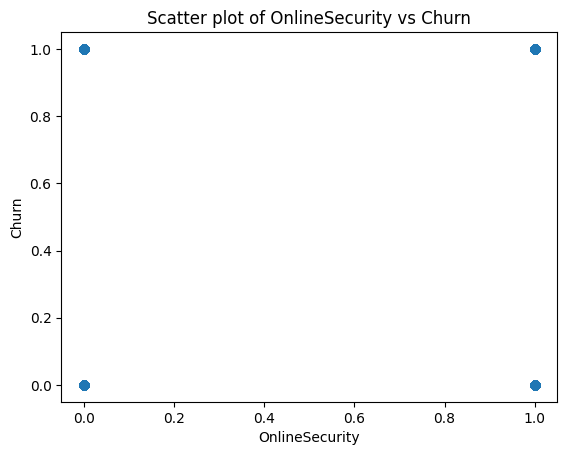

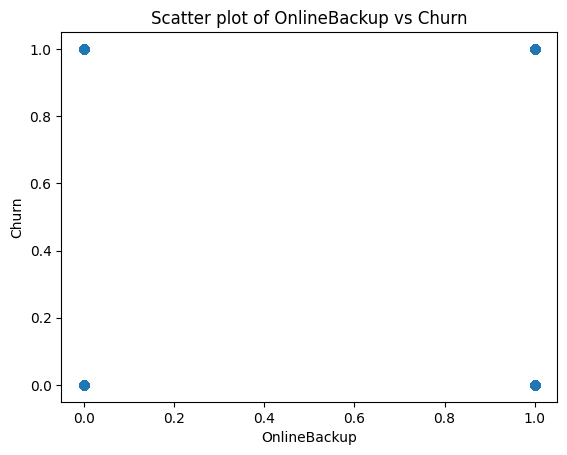

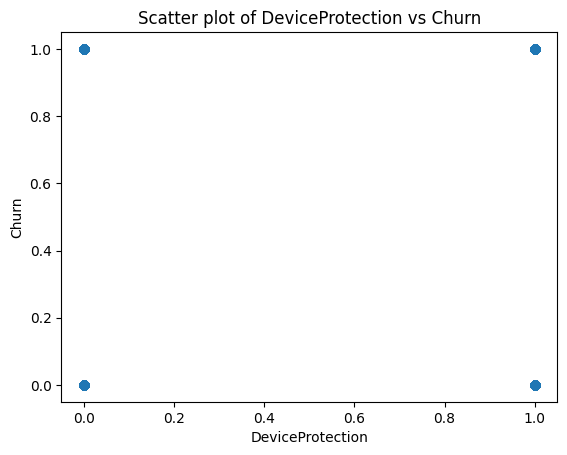

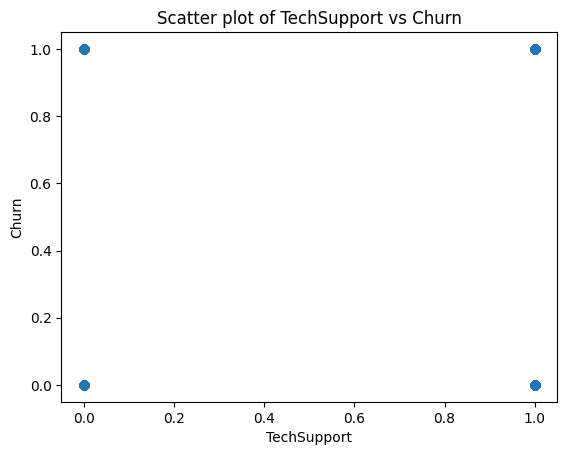

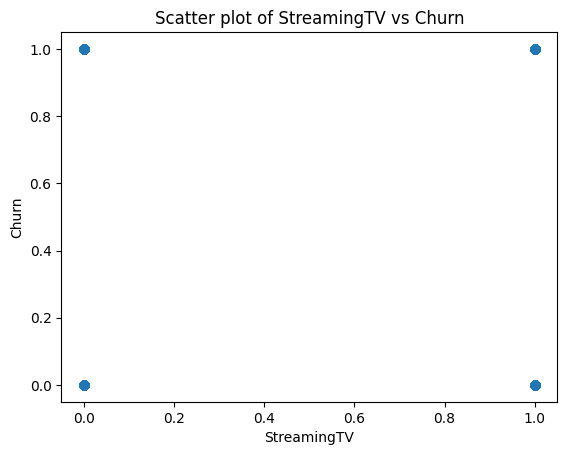

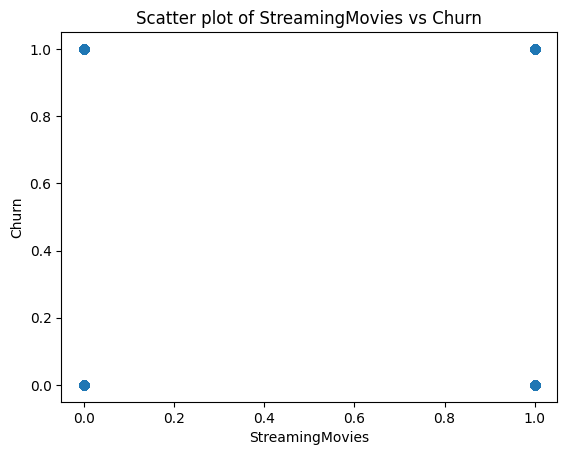

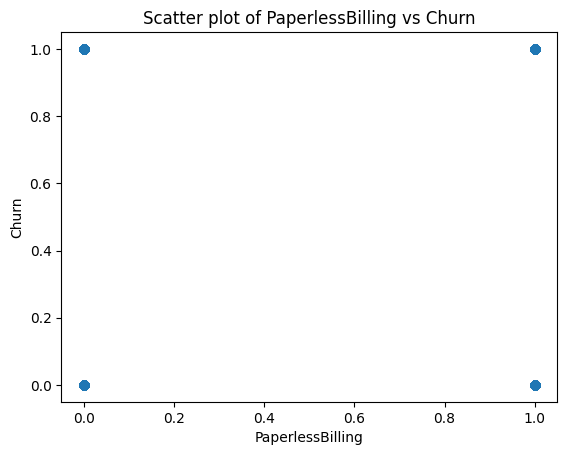

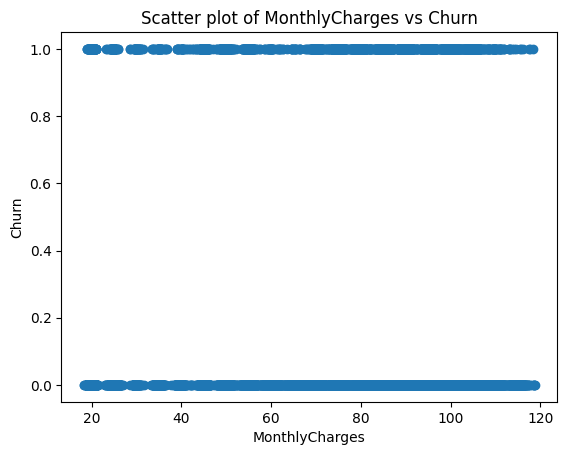

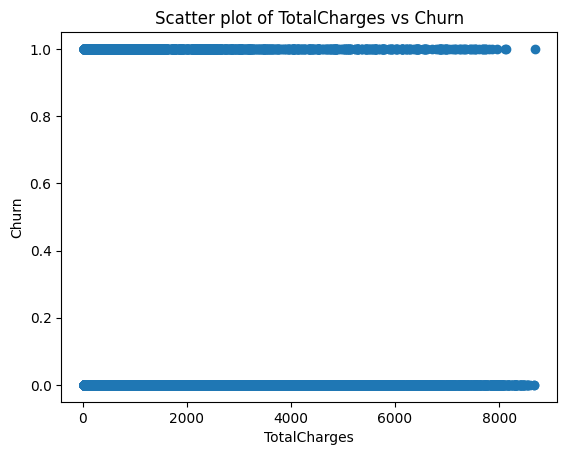

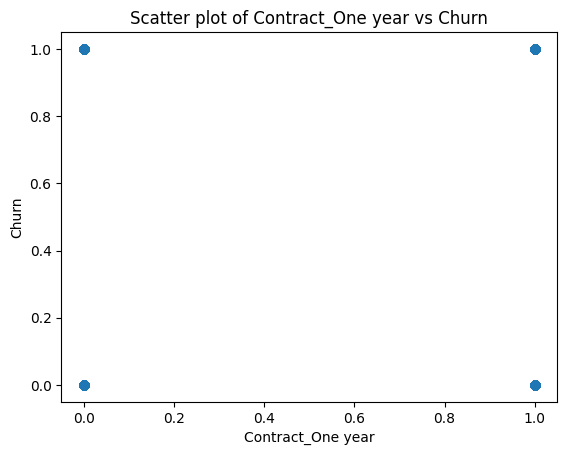

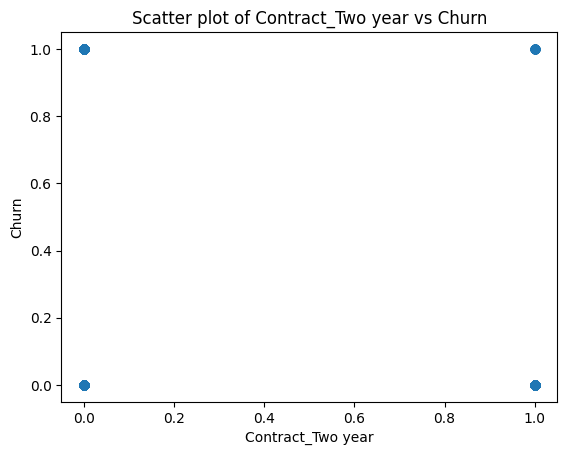

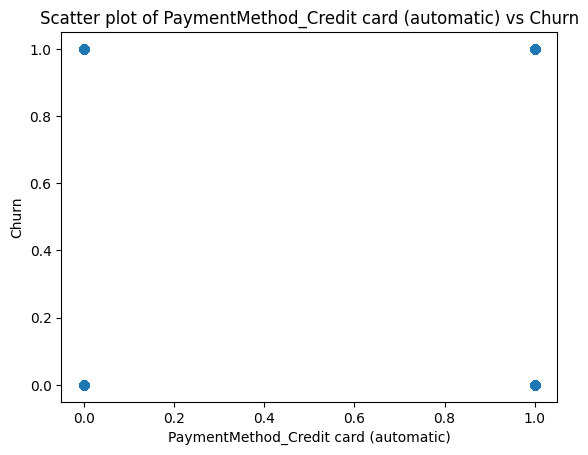

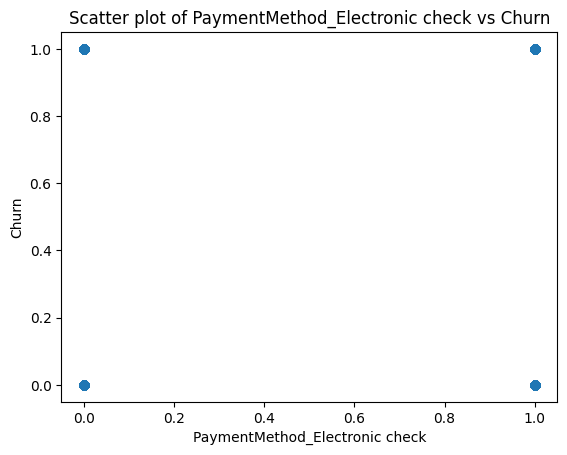

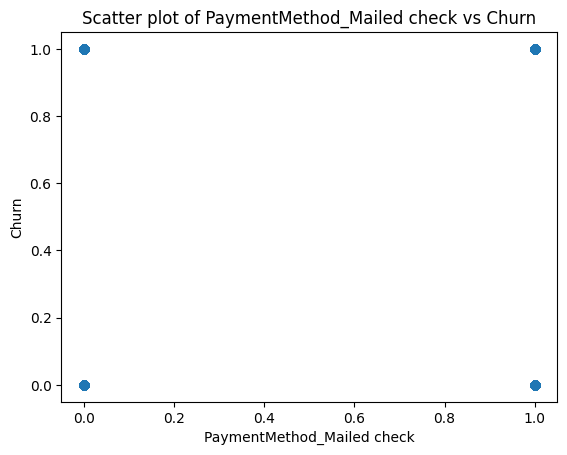

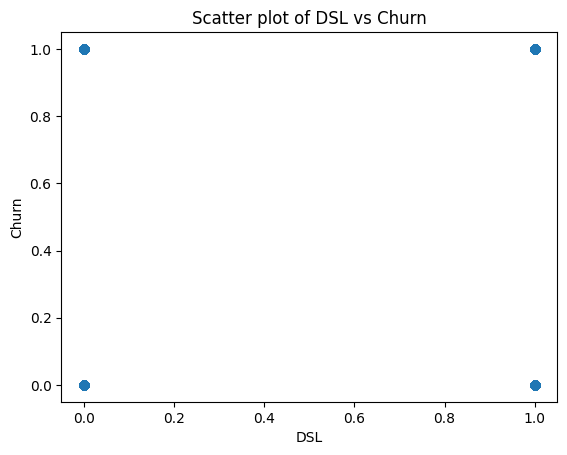

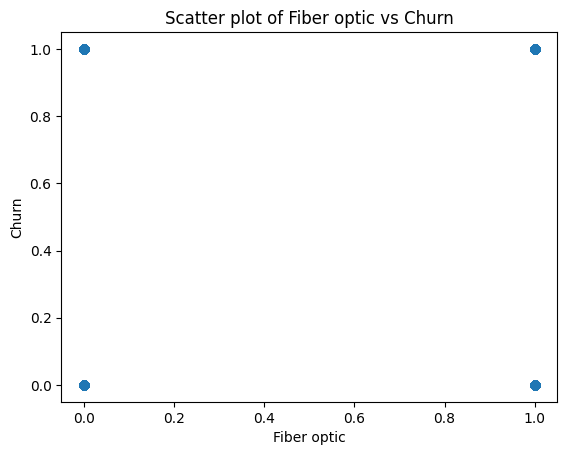

In [11]:
x_col = df.drop('Churn',axis = 1) #corrected by GPT4o on 1/22/2025 at 10:53p
Y = df['Churn']

for col in x_col:
    plt.scatter(x_col[col], Y) #generated by GPT4o on 1/22/2025 at 10:57p
    plt.xlabel(col)
    plt.ylabel('Churn')
    plt.title(f'Scatter plot of {col} vs Churn')
    plt.show()

### Linearity is not met, as Y is a binary variable that inherently violates the assumption of normality.

## Independence of Observation

In [12]:
# Add constant to ind. variables
X = sm.add_constant(x_col)
model = sm.OLS(Y, X).fit()

# Calculate the Durbin-Watson statistic
dw_stat = durbin_watson(model.resid) #generated by GPT4o on 1/22/2025 at 11:03p

print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 2.0043473189317393


### Interpretation: Because the Durbin-Watson statistic = 2, residuals are independent, suggesting that there is independence of observation.

## Homoscedasticity

In [13]:
# White Test
white_test = het_white(model.resid, X) #generated by GPT4o on 1/22/2025 at 11:08p
lm_stat, lm_p_value, f_stat, f_p_value = white_test #generated by GPT4o on 1/22/2025 at 11:08p

print(f"LM Statistic: {lm_stat}")
print(f"LM Test P-Value: {lm_p_value}")
print(f"F-Statistic: {f_stat}")
print(f"F-Test P-Value: {f_p_value}")

LM Statistic: 1783.5883698479759
LM Test P-Value: 5.493517042173264e-223
F-Statistic: 8.676665642569365
F-Test P-Value: 1.2975016139646177e-266


### Interpretation: the p-values of the LM, F-Tests indicate that there is heteroscedasticity. This is expected as Y being binary violates the assumption of normality.

## Normality of Residuals

In [14]:
# Extract Residuals
residuals = model.resid #generated by GPT4o on 1/22/2025 at 11:13p
stat, p_value = shapiro(residuals) #generated by GPT4o on 1/22/2025 at 11:13p

print(f"Shapiro-Wilk Test Stat: {stat}")
print(f"p-value: {p_value}")



Shapiro-Wilk Test Stat: 0.9620382866355719
p-value: 2.078878702766084e-39


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7032.
  # backward compatibility.


### Interpretation: Because the p-value < the critical threshold of 0.05, we can infer that the residuals are not normally distributed

## Multicollinearity

In [15]:
#VIF
vif_data = pd.DataFrame()


vif_data['Variable'] = x_col.columns #generated by GPT4o on 1/22/2025 at 11:19p
vif_data['VIF'] = [variance_inflation_factor(x_col.values, i) for i in range(x_col.shape[1])] #generated by GPT4o on 1/22/2025 at 11:19p

print(vif_data)

                                 Variable          VIF
0                                  gender     1.933709
1                           SeniorCitizen     1.372696
2                                 Partner     2.821024
3                              Dependents     1.959442
4                                  tenure    16.217728
5                            PhoneService   354.827295
6                           MultipleLines    12.588447
7                          OnlineSecurity     8.880461
8                            OnlineBackup    10.374210
9                        DeviceProtection    10.553362
10                            TechSupport     9.120960
11                            StreamingTV    39.114029
12                        StreamingMovies    39.490550
13                       PaperlessBilling     2.918397
14                         MonthlyCharges  4883.329541
15                           TotalCharges    17.679124
16                      Contract_One year     2.029145
17        

### There are some highly correlated variables; this makes sense as many variables are dependent on others (whether customers pay for phone service, internet service, etc).

## Influential Outliers

In [16]:
# Cook's distance

influence = OLSInfluence(model)
cooks_d = influence.cooks_distance[0] #generated by GPT4o on 1/22/2025 at 11:35p
threshold = 4 / len(df)
influential_points = [i for i, d in enumerate(cooks_d) if d > threshold] #generated by GPT4o on 1/22/2025 at 11:35p

print(f"Number of Influential Points: {len(influential_points)}")
print(f"Influential Points: {influential_points}")


Number of Influential Points: 285
Influential Points: [18, 31, 104, 131, 168, 173, 268, 317, 320, 335, 358, 385, 402, 430, 481, 494, 543, 572, 594, 608, 610, 637, 640, 657, 677, 797, 808, 809, 826, 828, 840, 853, 866, 871, 887, 972, 1012, 1118, 1167, 1198, 1255, 1259, 1302, 1310, 1335, 1360, 1390, 1391, 1472, 1489, 1517, 1542, 1550, 1563, 1570, 1572, 1607, 1653, 1696, 1714, 1775, 1781, 1835, 1851, 1923, 1945, 1962, 1976, 1980, 2000, 2014, 2024, 2065, 2069, 2096, 2122, 2125, 2199, 2239, 2277, 2280, 2282, 2292, 2295, 2388, 2407, 2419, 2514, 2524, 2531, 2559, 2603, 2605, 2609, 2633, 2747, 2770, 2775, 2799, 2807, 2817, 2885, 2889, 2957, 3014, 3023, 3024, 3035, 3037, 3050, 3053, 3106, 3134, 3173, 3189, 3192, 3235, 3321, 3409, 3433, 3442, 3511, 3528, 3571, 3580, 3666, 3674, 3681, 3688, 3773, 3782, 3784, 3793, 3797, 3827, 3837, 3842, 3870, 3883, 3917, 3920, 3938, 3939, 3964, 3987, 4071, 4075, 4121, 4133, 4142, 4167, 4234, 4248, 4251, 4255, 4258, 4259, 4265, 4280, 4289, 4378, 4387, 4394, 4410,

### It appears, based on Cook's distance, that there are a significant number of outliers.

# 2. Linear Regression

In [17]:
# For reference: x_col = independent variables, Y = dependent variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_col, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# Model Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred

In [19]:
# Fit LR Model
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")


Linear Regression:
MSE: 0.15
R2 Score: 0.25
const: 0.0018
gender: 0.0201
SeniorCitizen: 0.0035
Partner: -0.0130
Dependents: -0.0463
tenure: 0.0127
PhoneService: 0.0338
MultipleLines: -0.0168
OnlineSecurity: 0.0036
OnlineBackup: 0.0102
DeviceProtection: -0.0172
TechSupport: 0.0449
StreamingTV: 0.0465
StreamingMovies: 0.0177
PaperlessBilling: -0.1109
MonthlyCharges: -0.1030
TotalCharges: -0.0477
Contract_One year: -0.0318
Contract_Two year: -0.0039
PaymentMethod_Credit card (automatic): 0.0295
PaymentMethod_Electronic check: -0.0027
PaymentMethod_Mailed check: 0.1107
DSL: 0.2516


### Each coeffient represents the change in probability (positive or negative) given one unit of change in the standard deviaiton of variable (not one absolute unit because of scaling), all else held constant. The performance of this model is weak, as the R2 is only 0.25.  The MSE is also moderately large.

# 3. Log Regression

In [20]:
# For reference: x_col = independent variables, Y = dependent variable

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(x_col, Y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Fit a Binomial GLM with Logit Link
X_train_const = add_constant(X_train_scaled)
X_test_const = add_constant(X_test_scaled)
glm = GLM(y_train, X_train_const, family=Binomial(link=Logit())) #refined by GPT4o on 1/23/2025 12:28a
glm_results = glm.fit()


In [22]:
# Calculate log likelihood ratios for Logistic & null models for pseudo R2
# Below generated by GPT4o on 1/23/2025 @ 11:01a
ll_model = glm_results.llf
ll_null = glm_results.llnull

pseudo_r2 = 1 - (ll_model / ll_null)
print(f"McFadden's Pseudo R^2: {pseudo_r2}")

McFadden's Pseudo R^2: 0.29142083068823066


In [23]:
# Make predictions
y_pred_glm = glm_results.predict(X_test_const)

# Calculate MSE and log-loss (more appropriate for binary)
mse_glm = mean_squared_error(y_test, y_pred_glm)
logloss_glm = log_loss(y_test, y_pred_glm) #suggested by GPT4o on 1/23/2025 at 12:32a

print(f"GLM MSE: {mse_glm:.4f}, Log-Loss: {logloss_glm:.4f}")

# Interpret GLM
print("\nGLM Coefficients:")
for feature, coef in zip(['Intercept'] + list(x_col.columns), glm_results.params): #refined by GPT4o on 1/23/2025 at 12:44a
    print(f"{feature}: {coef:.4f}")

print("\nGLM Odds Ratios per Variable:")
for feature, coef in zip(['Intercept'] + list(x_col.columns), glm_results.params):
    odds_ratio = round(np.exp(coef), 4)  #generated by GPT4o on 1/23/2025 at 12:53a
    print(f"{feature}: {odds_ratio}")

print("\nGLM Probability per Variable:")
for feature, coef in zip(['Intercept'] + list(x_col.columns), glm_results.params):
    odds_ratio = round(np.exp(coef)/(1+np.exp(coef)), 4)  #generated by GPT4o on 1/23/2025 at 12:53a
    print(f"{feature}: {odds_ratio}")


GLM MSE: 0.1408, Log-Loss: 0.4325

GLM Coefficients:
Intercept: -1.7510
gender: 0.0151
SeniorCitizen: 0.0954
Partner: 0.0252
Dependents: -0.0987
tenure: -1.5111
PhoneService: 0.1723
MultipleLines: 0.2581
OnlineSecurity: -0.0672
OnlineBackup: 0.0837
DeviceProtection: 0.1321
TechSupport: -0.0542
StreamingTV: 0.4035
StreamingMovies: 0.4142
PaperlessBilling: 0.1339
MonthlyCharges: -1.8346
TotalCharges: 0.7621
Contract_One year: -0.3145
Contract_Two year: -0.5737
PaymentMethod_Credit card (automatic): -0.0582
PaymentMethod_Electronic check: 0.1230
PaymentMethod_Mailed check: -0.0301
DSL: 1.0647
Fiber optic: 2.2538

GLM Odds Ratios per Variable:
Intercept: 0.1736
gender: 1.0152
SeniorCitizen: 1.1001
Partner: 1.0255
Dependents: 0.906
tenure: 0.2207
PhoneService: 1.1881
MultipleLines: 1.2945
OnlineSecurity: 0.9351
OnlineBackup: 1.0873
DeviceProtection: 1.1412
TechSupport: 0.9473
StreamingTV: 1.4971
StreamingMovies: 1.5132
PaperlessBilling: 1.1433
MonthlyCharges: 0.1597
TotalCharges: 2.1428
Con

### When all independent variables are 0, the probability of churn is around 14.8%. Each coefficient represents the change in log-odds based on a one unit increase in X. The log-odds can then be used to calculate the magnitude of the change in odds ratio (and probability) given a one-unit change in X.

# 4. Generalized Additive Model (GAM)

In [126]:
num_variables = X_train_scaled.shape[1]
print(f"Number of variables: {num_variables}")

Number of variables: 23


In [137]:
# Initilize GAM
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22))

# Find best smoothing parameters for each spline term
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test_scaled)

# Calculate MSE and R^2
accuracy = accuracy_score(y_test, y_pred_gam)

print(f"GAM Accuracy Score: {accuracy:.4f}")

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:45 Time:  0:00:45


GAM Accuracy Score: 0.7925
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      34.203
Link Function:                        LogitLink Log Likelihood:                                 -2262.2437
Number of Samples:                         5625 AIC:                                             4592.8933
                                                AICc:                                            4593.3494
                                                UBRE:                                               2.8214
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3054
Feature Fu

<ipython-input-137-c878cfbb1deb>:18: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


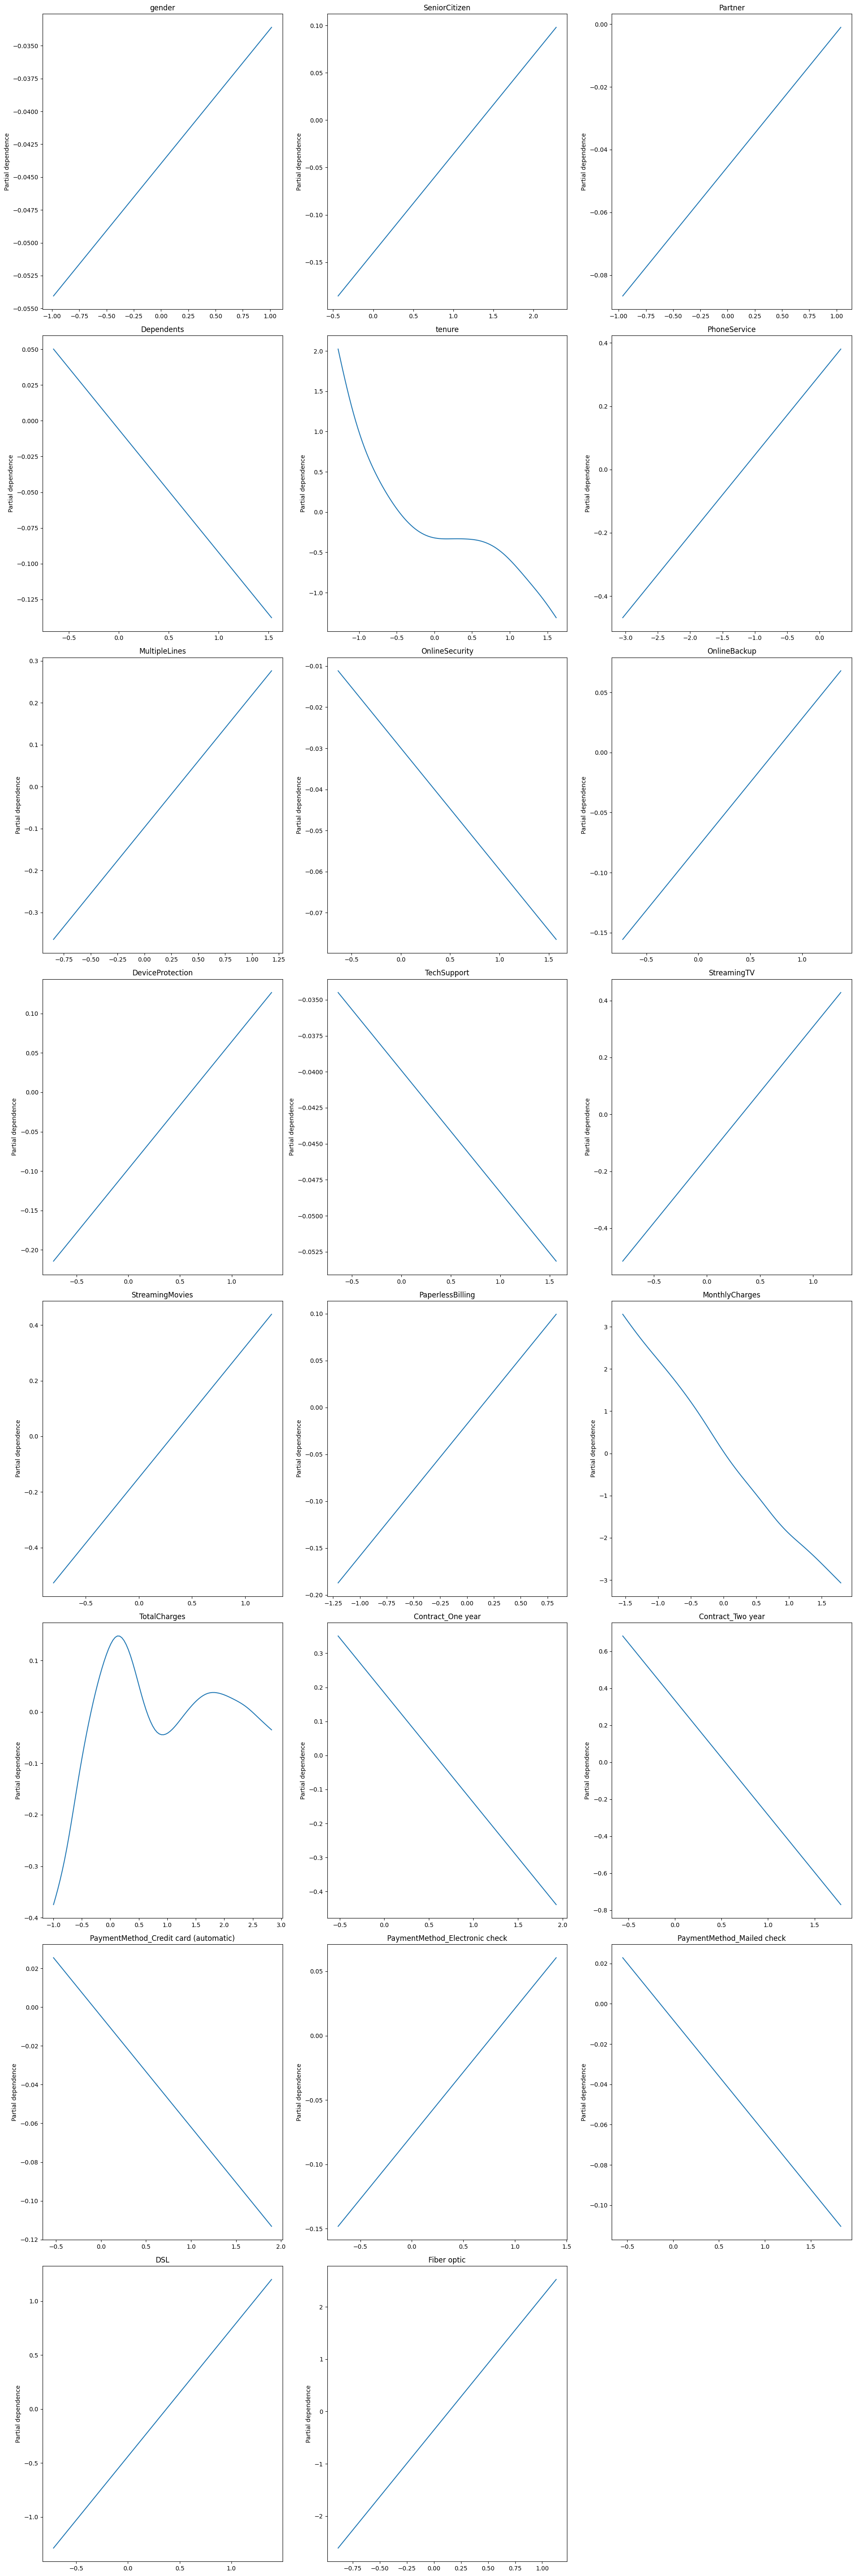

In [138]:
# Visualize GAM
plt.figure(figsize=(20, 60))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(8, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(x_col.columns[i])
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()

### Interpretation: The visuals show that some variables have linear relationships with the dependent variable, and some have non-linear relationships — namely total charges and tenure. The variables that have a significant effect on churn are senior citizen status, tenure, multiple lines, streaming tv, streaming movies, paperless billing, total charges, contract (one year), contract (two-year), DSL, & fiber optic. The directionality of the plots indicate a positive or negative effect on the churn. The peformance of the model, as indicated by by the GAM Accuracy Score, is significantly more robust than other models.

# 5. Model Comparison

### For this application, the linear regression model can effectively be ruled out given that it is not suitable for a binary dependent variable, as it assumes a continuous target and can result in outcomes that are outside of the bounds of 0 and 1. While the coefficients are interpretable, they are not suitable for accurately demonstrating feature effects on probabilities. As such, we can observe that the R2 is 0.25, a relatively measure of performance.

### The logistic regression is a more suitable model given the binary nature of churn. The coefficients are also interpretable given that they represent the change in log-odds for every one-unit change in the feature. They can also be transformed into probabilities for interpretation. The log loss is 0.43, which indicates moderate performance.

### Finally, the binomial GAM model removes the assumption of linearity in both the linear and logistic regressions, which allows it to capture more complex relationships as with tenure and total charges. The GAM accuracy is ~0.8, which suggests strong performance. Relatively to the logistic regression, the GAM model has a higher pseudo R2, indicating stronger relative performance. The binomial GAM model is interpretablee by analyzing the significance of splines and the visualizations of the smooth terms.

### I would recommend the GAM model, as it offers a balance of performance and interpretability, and also accounts for the nonlinearity of relationships. However, in cases that call for discrete, numeric explanations of effect on proabilities, I would recommend the logistic model.